In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from scipy import stats

/var/folders/lr/2ljfkpxj1851pmkswdvzvnhm0000gn/T/ipykernel_12525/2214738656.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Load sales of smartphones in India (Rupee)
data = pd.read_csv("Sales.csv")
data.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8 GB,128 GB,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2 GB,16 GB,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000
2,realme,C2,Diamond Black,2 GB,NaN,Yes,4.4,6999,7999,realme C2,1000,12.501563
3,Infinix,Note 5,Ice Blue,4 GB,64 GB,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4GB,64 GB,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000


In [3]:
data.dtypes

Brands                  object
Models                  object
Colors                  object
Memory                  object
Storage                 object
Camera                  object
Rating                 float64
Selling Price            int64
Original Price           int64
Mobile                  object
Discount                 int64
discount percentage    float64
dtype: object

In [4]:
data.describe()

,Rating,Selling Price,Original Price,Discount,discount percentage
count,2970.000000,3114.000000,3114.000000,3114.000000,3114.000000
mean,4.243098,26436.625562,28333.473025,1896.847463,6.086788
std,0.271991,30066.892622,31525.599889,5337.126176,11.106776
min,2.300000,1000.000000,1000.000000,-8000.000000,-160.320641
25%,4.100000,9990.000000,10030.250000,0.000000,0.000000
50%,4.300000,15000.000000,16889.500000,0.000000,0.000000
75%,4.400000,28999.000000,31500.000000,2000.000000,9.836388
max,5.000000,179900.000000,189999.000000,75000.000000,70.610305


In [5]:
data.shape

(3114, 12)

discount percentage    0.049209
Discount               0.351638
Rating                 0.451354
Selling Price          0.986097
Original Price         1.000000
Name: Original Price, dtype: float64


<Axes: >

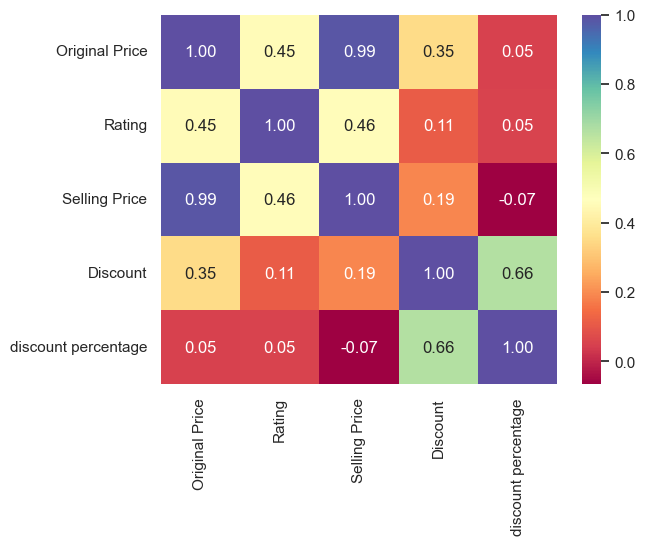

In [6]:
numeric_data = pd.DataFrame(data[["Original Price","Rating", "Selling Price", "Discount", "discount percentage"]])
corr = numeric_data.corr()

# Pearson Correlation Coefficient 
# measures the strength and direction of the relationship between the predictor and response variables
print(corr['Original Price'].sort_values())
sb.heatmap(corr, annot=True, cmap="Spectral", fmt='.2f')

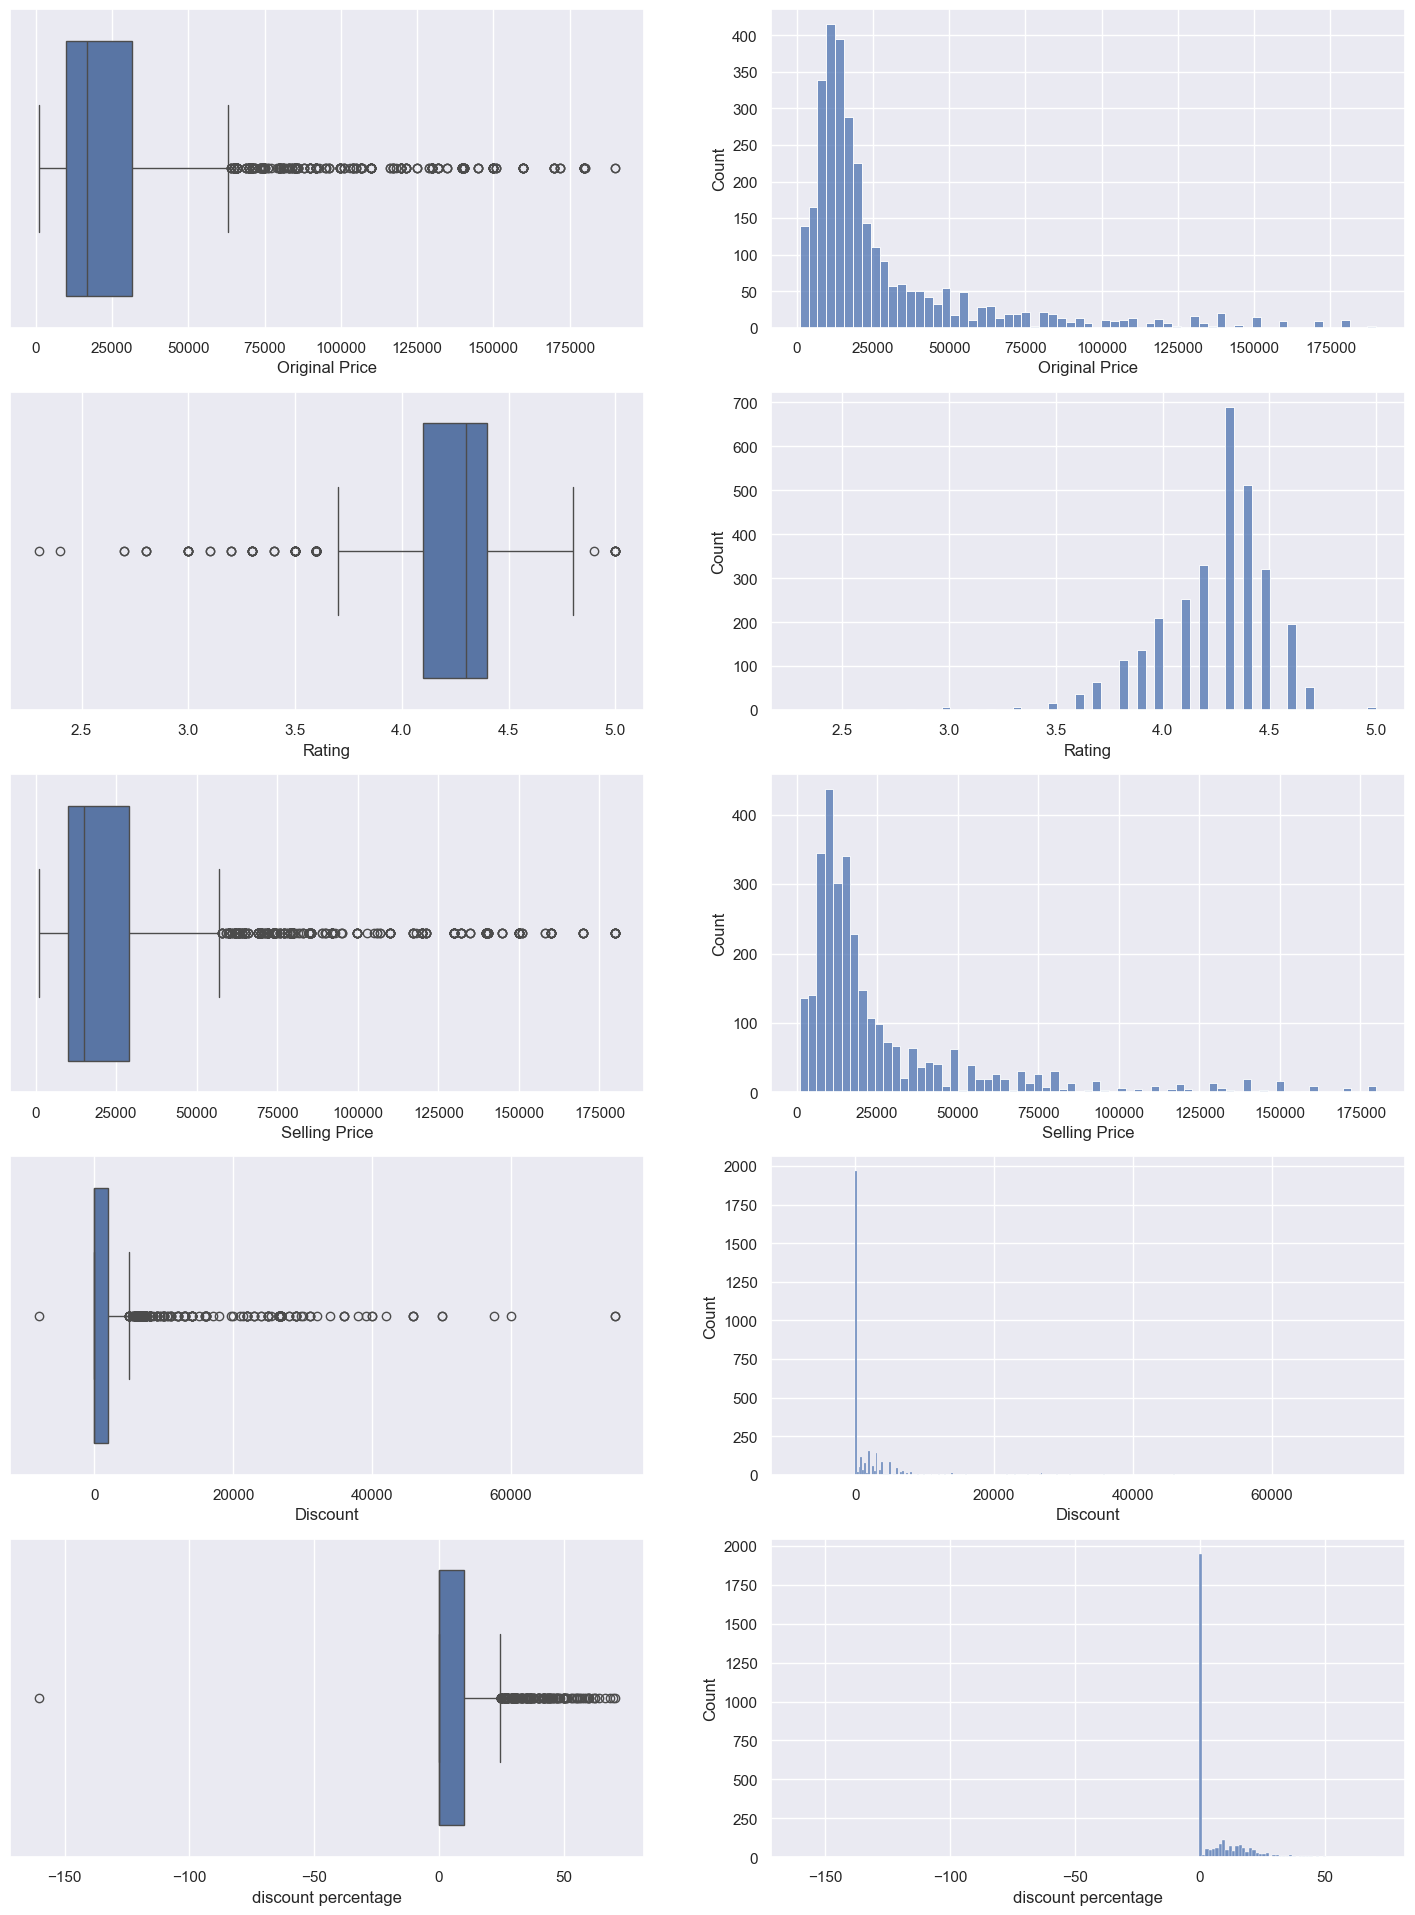

In [7]:
### Boxplots of numeric variables

var = ["Original Price", "Rating", "Selling Price", "Discount", "discount percentage"]
f, axes = plt.subplots(5,2, figsize=(18,24))

count = 0

for var in numeric_data:
    sb.boxplot(data=numeric_data[var], orient="h", ax = axes[count,0])
    sb.histplot(data = numeric_data[var], ax = axes[count,1])
    count += 1

In [8]:
#Calculate outliers
Q1 = data['Original Price'].quantile(0.25)
Q3 = data['Original Price'].quantile(0.75)

IQR = Q3-Q1

lowerBound = Q1-(1.5*IQR)
upperBound = Q3+(1.5*IQR)

#identify all outliers

outliers = data[(data['Original Price'] < lowerBound) | (data['Original Price']> upperBound)]

print("Number of outliers in Original Selling Price: {}".format(len(outliers)))

# data = data.query("Brands == 'Apple'")

Number of outliers in Original Selling Price: 345


In [9]:
#Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    
    lowerBound = Q1-(1.5*IQR)
    upperBound = Q3+(1.5*IQR)
    
    df_filtered = df.loc[(df[column] >= lowerBound) & (df[column] <= upperBound)]
    
    return df_filtered


# Remove outliers in the original selling price
filtered_data = remove_outliers(data, "Original Price")
#df[df['Brands'].str.contains("Apple")].head(400)

In [10]:
#Count the number of null values in the data
filtered_data.isna().sum()

Brands                  0
Models                  0
Colors                  0
Memory                 29
Storage                36
Camera                  0
Rating                 85
Selling Price           0
Original Price          0
Mobile                  0
Discount                0
discount percentage     0
dtype: int64

In [11]:
#Remove all the null values in the data
filtered_data = filtered_data.dropna()

In [12]:
#After the removal of null values
filtered_data.shape

(2625, 12)

In [13]:
filtered_data['Storage'] = filtered_data['Storage'].str.replace("Expandable Upto", "")

In [14]:
#filtered_data["Memory"] = filtered_data['Memory'].str.replace('GB', " GB")
#filtered_data = filtered_data.reset_index()

#Convert to GB
def convert_to_gb(size_str):
    if "MB" in size_str:
        return float(size_str.replace("MB", "")) / 1000
    elif "TB" in size_str:
        return float(size_str.replace("TB", "")) * 1000
    elif "GB" in size_str:
        return float(size_str.replace("GB", ""))
    else:
        return None


filtered_data["Memory"] = filtered_data['Memory'].apply(convert_to_gb)
filtered_data['Storage'] = filtered_data['Storage'].apply(convert_to_gb)
filtered_data.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8.000,128.000,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2.000,16.000,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000
3,Infinix,Note 5,Ice Blue,4.000,64.000,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4.000,64.000,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000
5,GIONEE,L800,Black,0.008,0.016,Yes,4.0,2199,2199,GIONEE L800,0,0.000000


In [15]:
filtered_data.dtypes

Brands                  object
Models                  object
Colors                  object
Memory                 float64
Storage                float64
Camera                  object
Rating                 float64
Selling Price            int64
Original Price           int64
Mobile                  object
Discount                 int64
discount percentage    float64
dtype: object

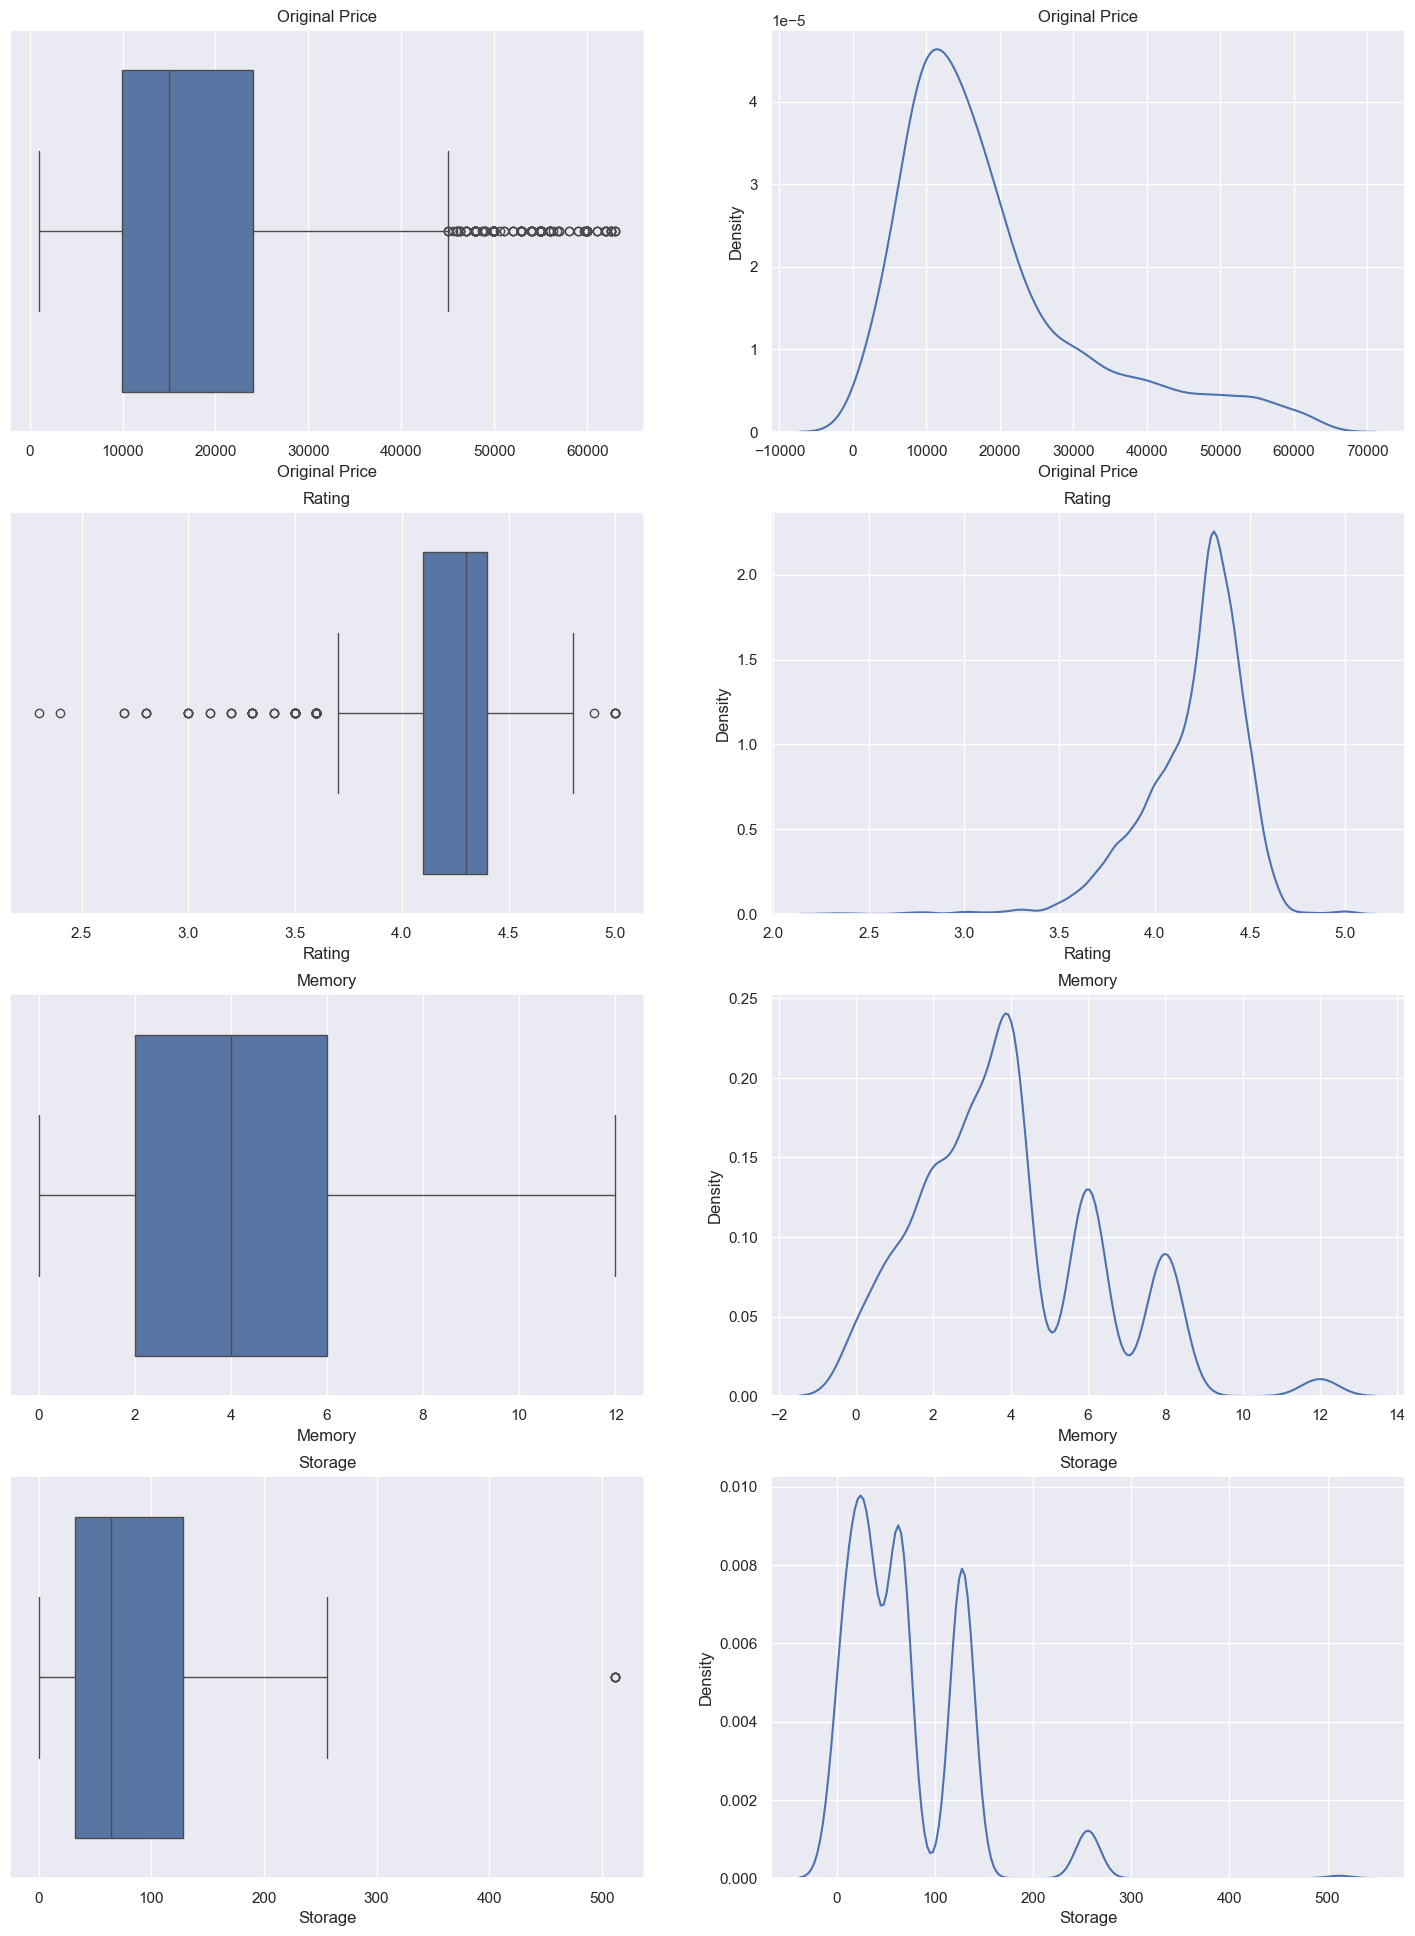

In [16]:
var = ["Original Price", "Rating", "Memory", "Storage"]
filtered_numeric_data = pd.DataFrame(filtered_data[["Original Price","Rating", "Memory", "Storage"]])
count = 0

f, axes = plt.subplots(4,2, figsize=(18,24))
for var in filtered_numeric_data:
    sb.boxplot(data = filtered_numeric_data[var], orient="h", ax = axes[count,0]).set_title(var)
    sb.kdeplot(data=filtered_numeric_data[var], ax = axes[count,1]).set_title(var)
    count+=1

Rating            0.417703
Memory            0.467205
Storage           0.540914
Original Price    1.000000
Name: Original Price, dtype: float64


<Axes: >

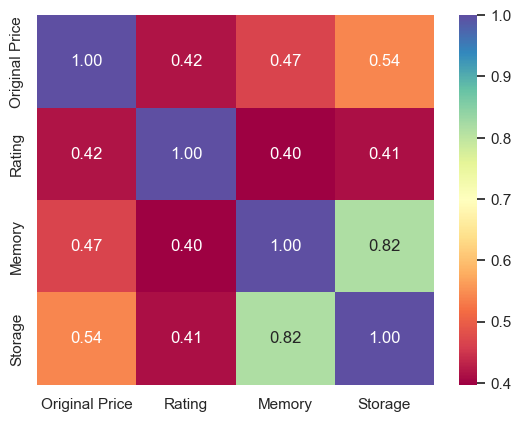

In [17]:
corr = filtered_numeric_data.corr()
print(corr['Original Price'].sort_values())
sb.heatmap(corr, annot=True, cmap="Spectral", fmt='.2f')

The relatively higher correlation coefficients of "Memory" (=0.47) and "Storage" (=0.54) variables with "Original Price" suggest that a decent linear regression model based on "Memory"/"Storage" as the predictor variables and "Original Price" as the response variable could be trained from the dataset  

Coefficients of Regression: 117.92125777112923
Intercept of Regression: 10816.992561050023


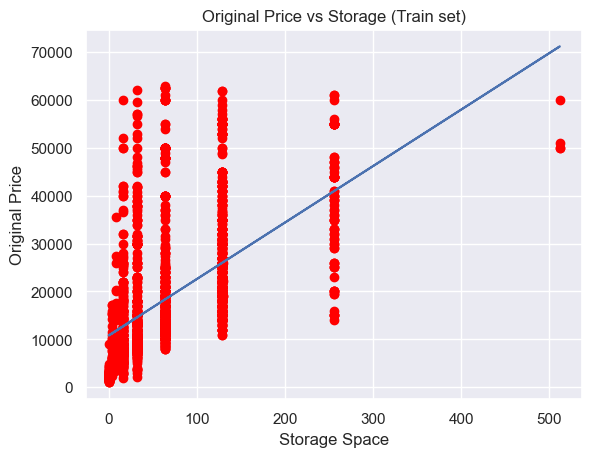

In [18]:
#Linear  Regression
storage = filtered_data[['Storage']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
storage_train, storage_test, originalPrice_train, originalPrice_test = train_test_split(storage, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(storage_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(storage_train, originalPrice_train, color='red')
plt.plot(storage_train, linreg.predict(storage_train))
plt.title("Original Price vs Storage (Train set)")
plt.xlabel('Storage Space')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.29461697973493095
Mean Squared Error (MSE): 119625394.74910179

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.2833069219556703
Mean Squared Error (MSE): 142405285.80540988


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

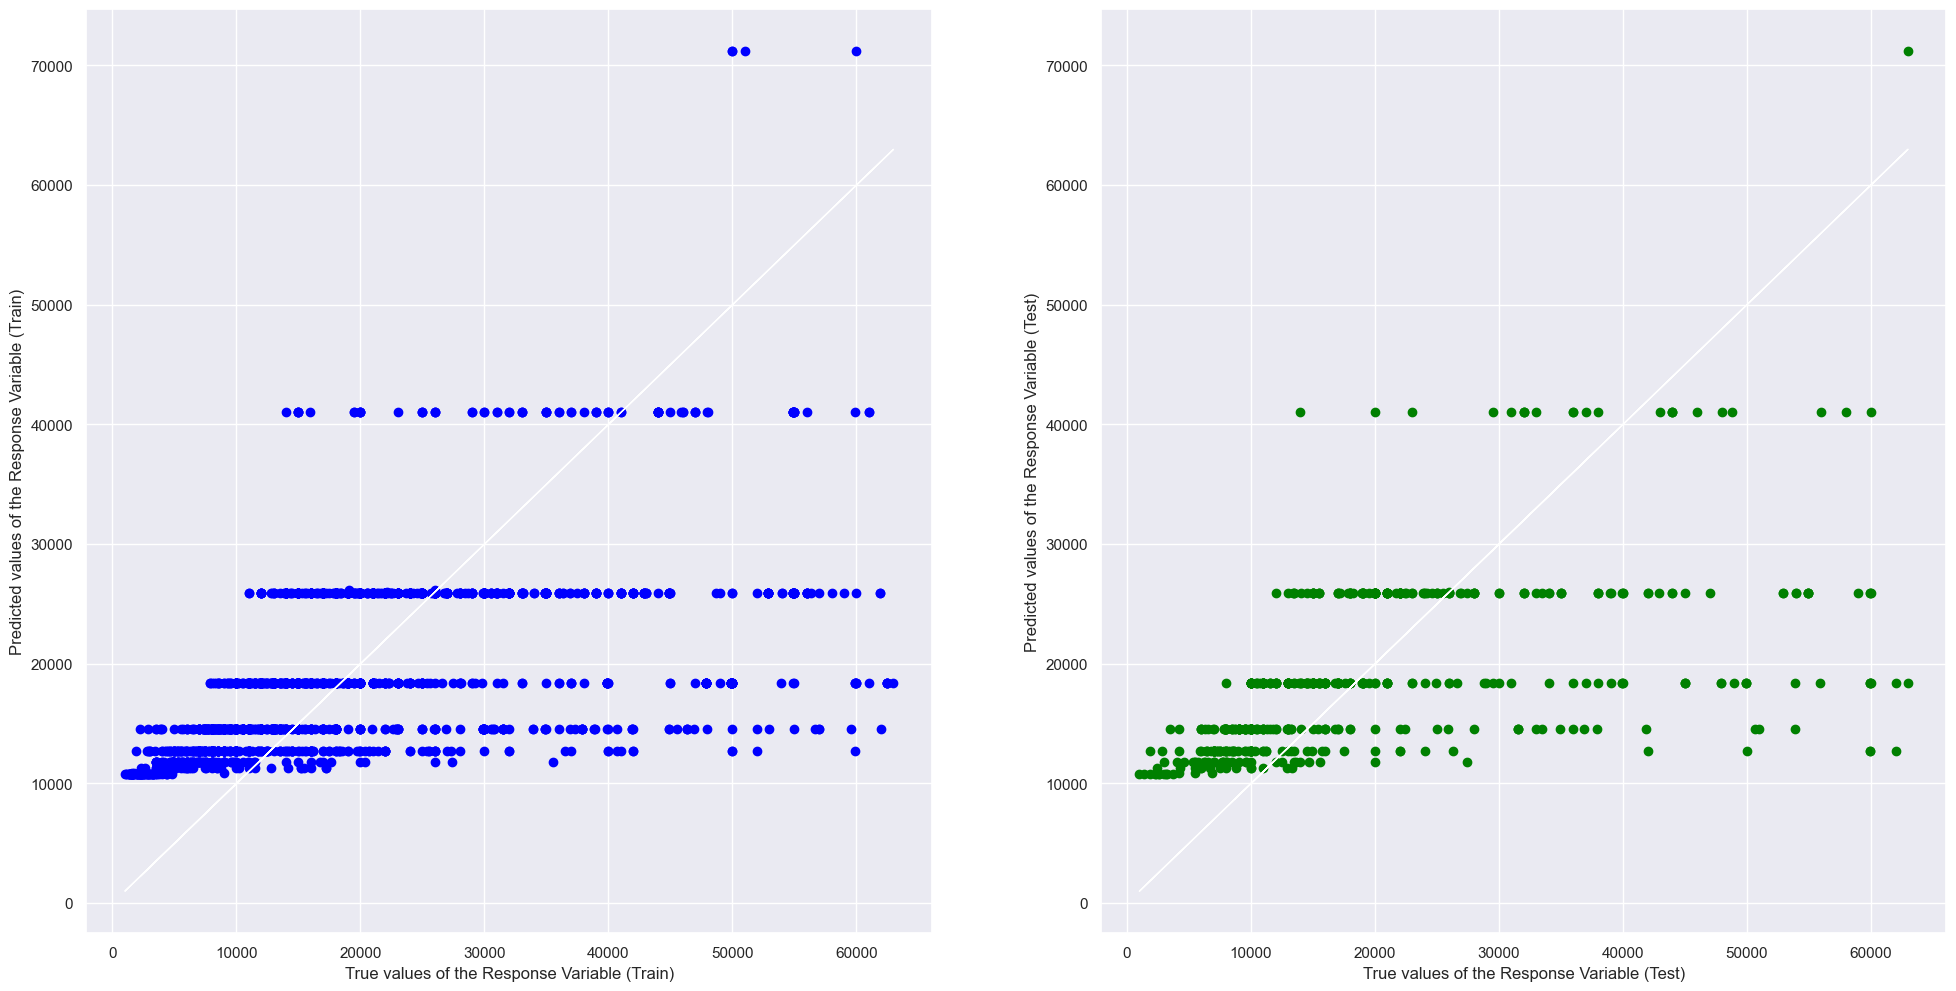

In [19]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(storage_test)
originalPrice_train_pred = linreg.predict(storage_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(storage_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(storage_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

Coefficients of Regression: 2634.7537447971904
Intercept of Regression: 8785.911764776884


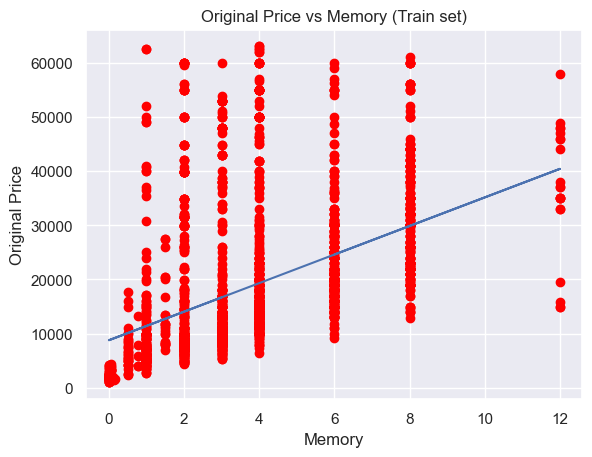

In [20]:
#Linear  Regression
memory = filtered_data[['Memory']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
memory_train, memory_test, originalPrice_train, originalPrice_test = train_test_split(memory, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(memory_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(memory_train, originalPrice_train, color='red')
plt.plot(memory_train, linreg.predict(memory_train))
plt.title("Original Price vs Memory (Train set)")
plt.xlabel('Memory')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.21313668144012865
Mean Squared Error (MSE): 134909196.95320198

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.2365764509570164
Mean Squared Error (MSE): 146360203.16912243


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

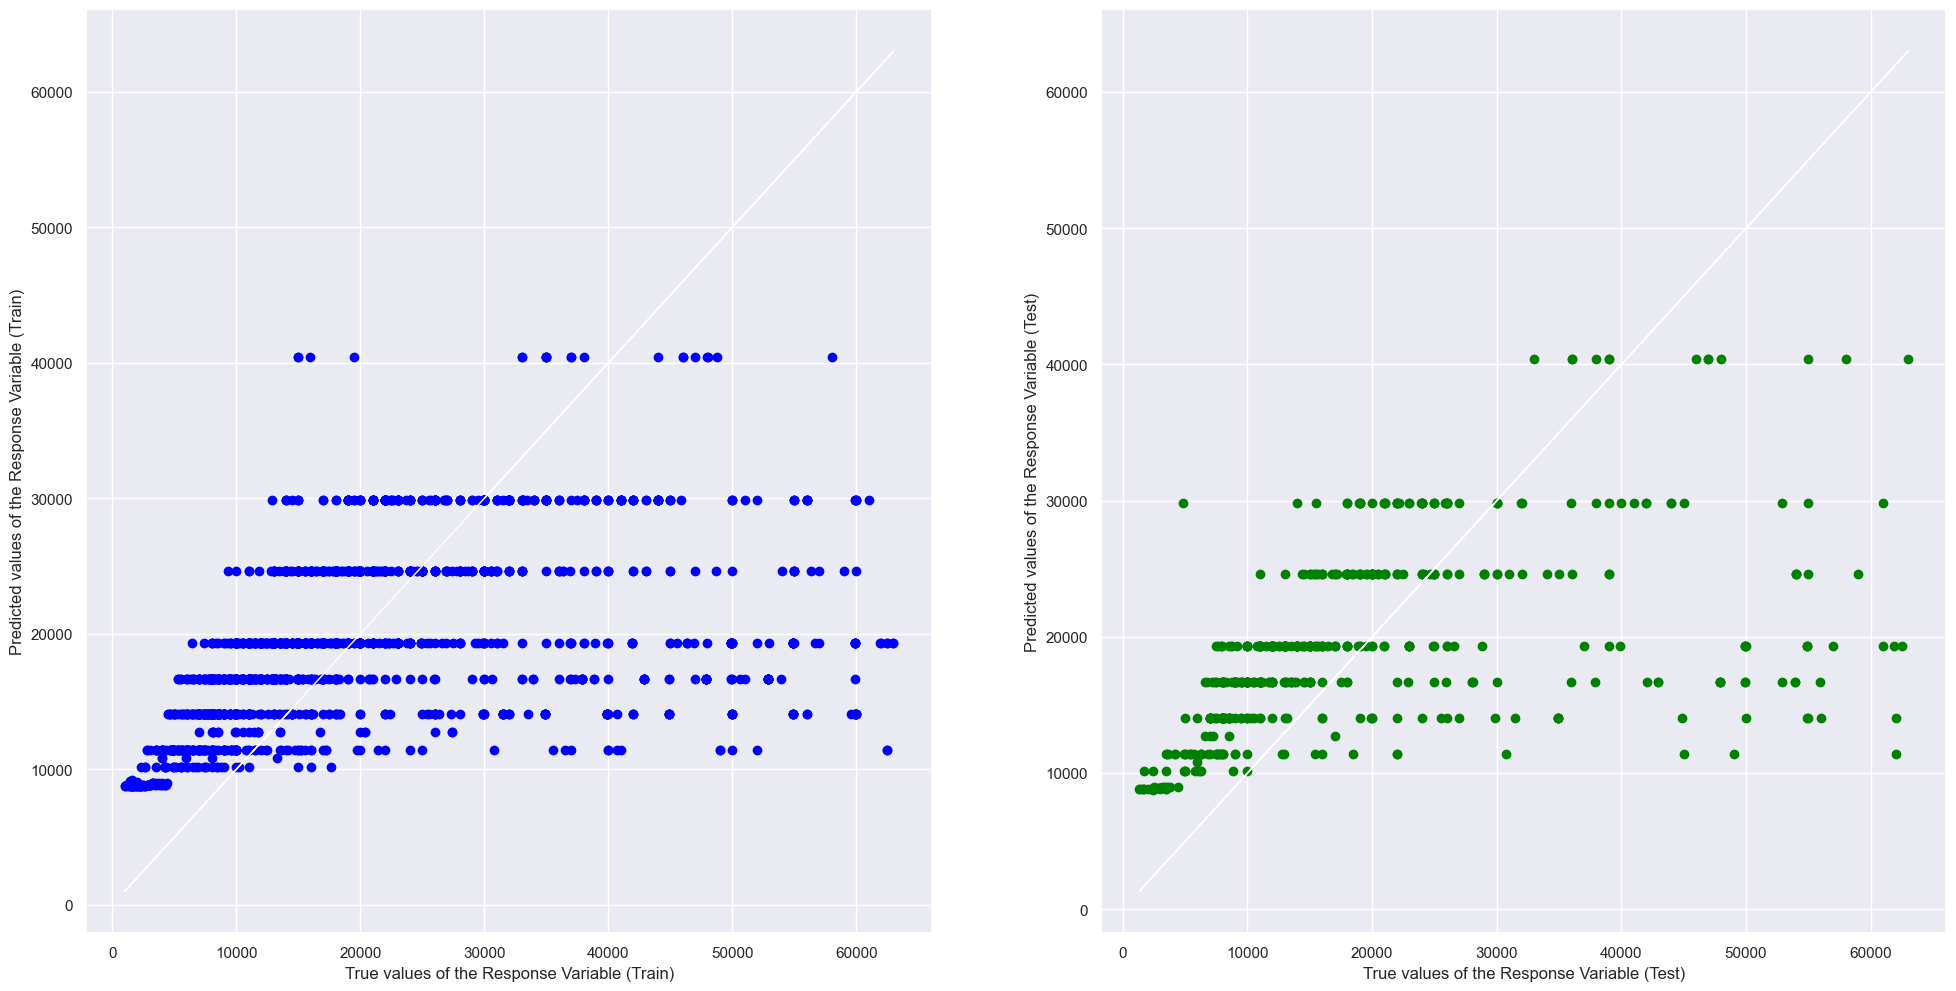

In [21]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(memory_test)
originalPrice_train_pred = linreg.predict(memory_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(memory_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(memory_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

Coefficients of Regression: 22356.475194610113
Intercept of Regression: -74898.15835868267


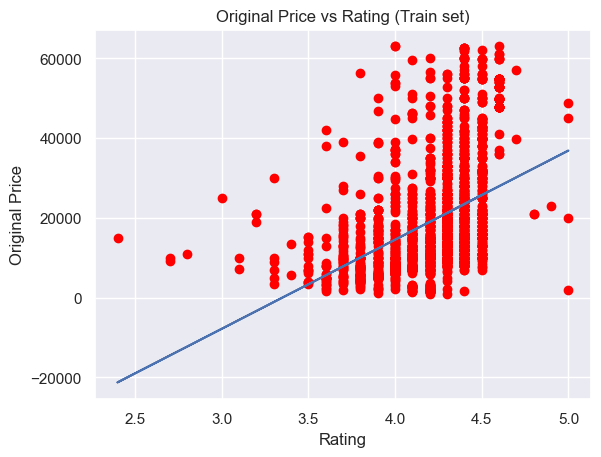

In [22]:
#Linear  Regression
rating = filtered_data[['Rating']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
rating_train, rating_test, originalPrice_train, originalPrice_test = train_test_split(rating, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(rating_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(rating_train, originalPrice_train, color='red')
plt.plot(rating_train, linreg.predict(rating_train))
plt.title("Original Price vs Rating (Train set)")
plt.xlabel('Rating')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.18306456889372635
Mean Squared Error (MSE): 146405203.00784662

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.12640169080955888
Mean Squared Error (MSE): 139350754.5998248


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

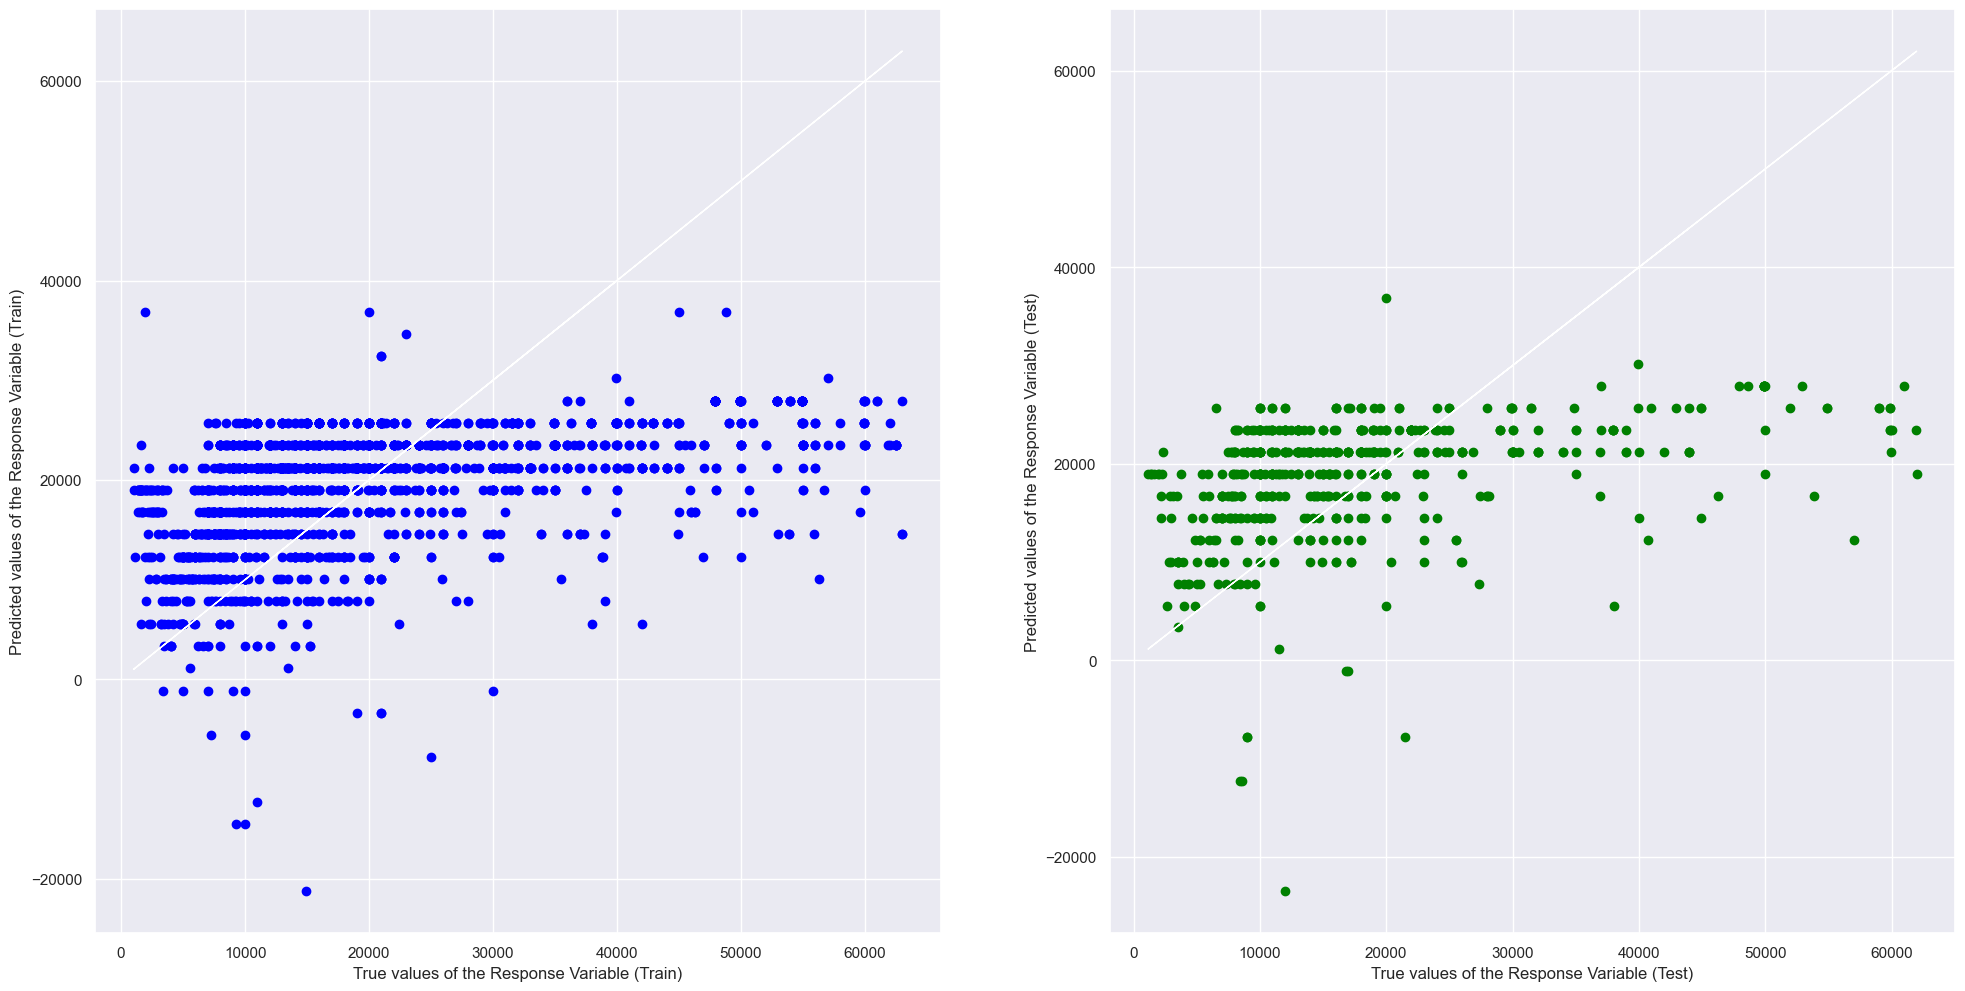

In [23]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(rating_test)
originalPrice_train_pred = linreg.predict(rating_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(rating_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(rating_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

Now, lets investigate whether there is perhaps a mutual relationship between brand and original price 

<Axes: xlabel='Original Price', ylabel='Brands'>

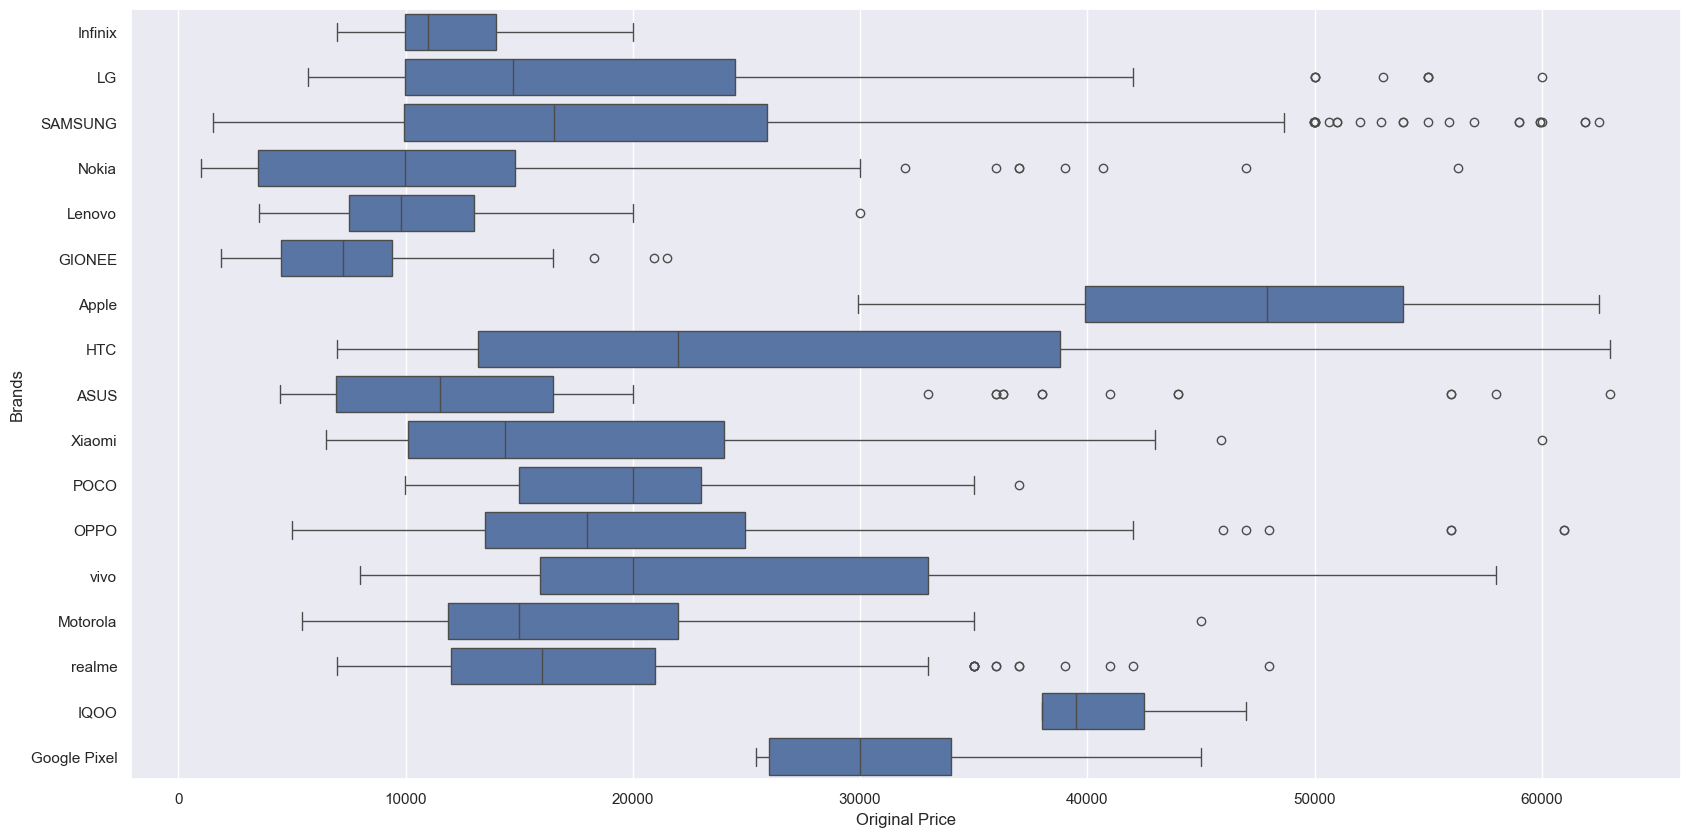

In [24]:
originalPrice = pd.DataFrame(filtered_data['Original Price'])
brands = pd.DataFrame(filtered_data['Brands'])

originalPrice_train, originalPrice_test, brands_train, brands_test = train_test_split(originalPrice, brands, test_size = 0.2)

joint = pd.concat([originalPrice_train, brands_train], axis=1).reindex(originalPrice_train.index)

f = plt.figure(figsize=(20,10))
sb.boxplot(x="Original Price", y="Brands", data = joint, orient="h")

In [25]:
#Function to split datapoints into 2 categories 

bins = [0, 30000, 70000]
labels = ["<= 30000", ">30000"]

filtered_data["Original Price"] = pd.cut(filtered_data["Original Price"], bins=bins, labels=labels)
filtered_data.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8.000,128.000,Yes,4.3,19330,<= 30000,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2.000,16.000,Yes,3.8,10199,<= 30000,Nokia 3.2,0,0.000000
3,Infinix,Note 5,Ice Blue,4.000,64.000,Yes,4.2,12999,<= 30000,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4.000,64.000,Yes,4.6,49900,>30000,Apple iPhone 11,0,0.000000
5,GIONEE,L800,Black,0.008,0.016,Yes,4.0,2199,<= 30000,GIONEE L800,0,0.000000


# Create a Classification Model

Let's start by encoding the levels of our categorical predictor variable ("Brands") as integers. We will do so by encoding the unordered categorical variable by integers. This method is OneHotEncoding from the sklearn preprocessing module.

In [26]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
predictor_variable_cat = filtered_data[['Brands']]
ohe.fit(predictor_variable_cat)
predictor_variable_cat_ohe = pd.DataFrame(ohe.transform(predictor_variable_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(predictor_variable_cat.columns))

# Check the encoded variables 
predictor_variable_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brands_ASUS          2625 non-null   float64
 1   Brands_Apple         2625 non-null   float64
 2   Brands_GIONEE        2625 non-null   float64
 3   Brands_Google Pixel  2625 non-null   float64
 4   Brands_HTC           2625 non-null   float64
 5   Brands_IQOO          2625 non-null   float64
 6   Brands_Infinix       2625 non-null   float64
 7   Brands_LG            2625 non-null   float64
 8   Brands_Lenovo        2625 non-null   float64
 9   Brands_Motorola      2625 non-null   float64
 10  Brands_Nokia         2625 non-null   float64
 11  Brands_OPPO          2625 non-null   float64
 12  Brands_POCO          2625 non-null   float64
 13  Brands_SAMSUNG       2625 non-null   float64
 14  Brands_Xiaomi        2625 non-null   float64
 15  Brands_realme        2625 non-null   f

In [27]:
# Combining Numeric features with the OHE Categorical features
filtered_data_num = filtered_data[['Memory','Storage','Rating']]
filtered_data_response = filtered_data['Original Price']

filtered_data_ohe = pd.concat([filtered_data_num, filtered_data_response ,predictor_variable_cat_ohe], 
                           sort = False, axis = 1).reindex(index=filtered_data_num.index)

# Check the final dataframe
filtered_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2625 entries, 0 to 3113
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Memory               2625 non-null   float64 
 1   Storage              2625 non-null   float64 
 2   Rating               2625 non-null   float64 
 3   Original Price       2625 non-null   category
 4   Brands_ASUS          2212 non-null   float64 
 5   Brands_Apple         2212 non-null   float64 
 6   Brands_GIONEE        2212 non-null   float64 
 7   Brands_Google Pixel  2212 non-null   float64 
 8   Brands_HTC           2212 non-null   float64 
 9   Brands_IQOO          2212 non-null   float64 
 10  Brands_Infinix       2212 non-null   float64 
 11  Brands_LG            2212 non-null   float64 
 12  Brands_Lenovo        2212 non-null   float64 
 13  Brands_Motorola      2212 non-null   float64 
 14  Brands_Nokia         2212 non-null   float64 
 15  Brands_OPPO          2212 

### Create and Fit the Model

Now, after the encoding is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

[Text(0.5446428571428571, 0.9, 'Rating <= 4.45\ngini = 0.288\nsamples = 2100\nvalue = [1734, 366]\nclass = <=30000'),
 Text(0.2857142857142857, 0.7, 'Memory <= 7.0\ngini = 0.21\nsamples = 1817\nvalue = [1600, 217]\nclass = <=30000'),
 Text(0.14285714285714285, 0.5, 'Storage <= 24.0\ngini = 0.139\nsamples = 1603\nvalue = [1483, 120]\nclass = <=30000'),
 Text(0.07142857142857142, 0.3, 'Rating <= 4.35\ngini = 0.035\nsamples = 447\nvalue = [439, 8]\nclass = <=30000'),
 Text(0.03571428571428571, 0.1, 'gini = 0.009\nsamples = 430\nvalue = [428, 2]\nclass = <=30000'),
 Text(0.10714285714285714, 0.1, 'gini = 0.457\nsamples = 17\nvalue = [11, 6]\nclass = <=30000'),
 Text(0.21428571428571427, 0.3, 'Memory <= 1.5\ngini = 0.175\nsamples = 1156\nvalue = [1044, 112]\nclass = <=30000'),
 Text(0.17857142857142858, 0.1, 'gini = 0.498\nsamples = 15\nvalue = [7, 8]\nclass = >30000'),
 Text(0.25, 0.1, 'gini = 0.166\nsamples = 1141\nvalue = [1037, 104]\nclass = <=30000'),
 Text(0.42857142857142855, 0.5, 'S

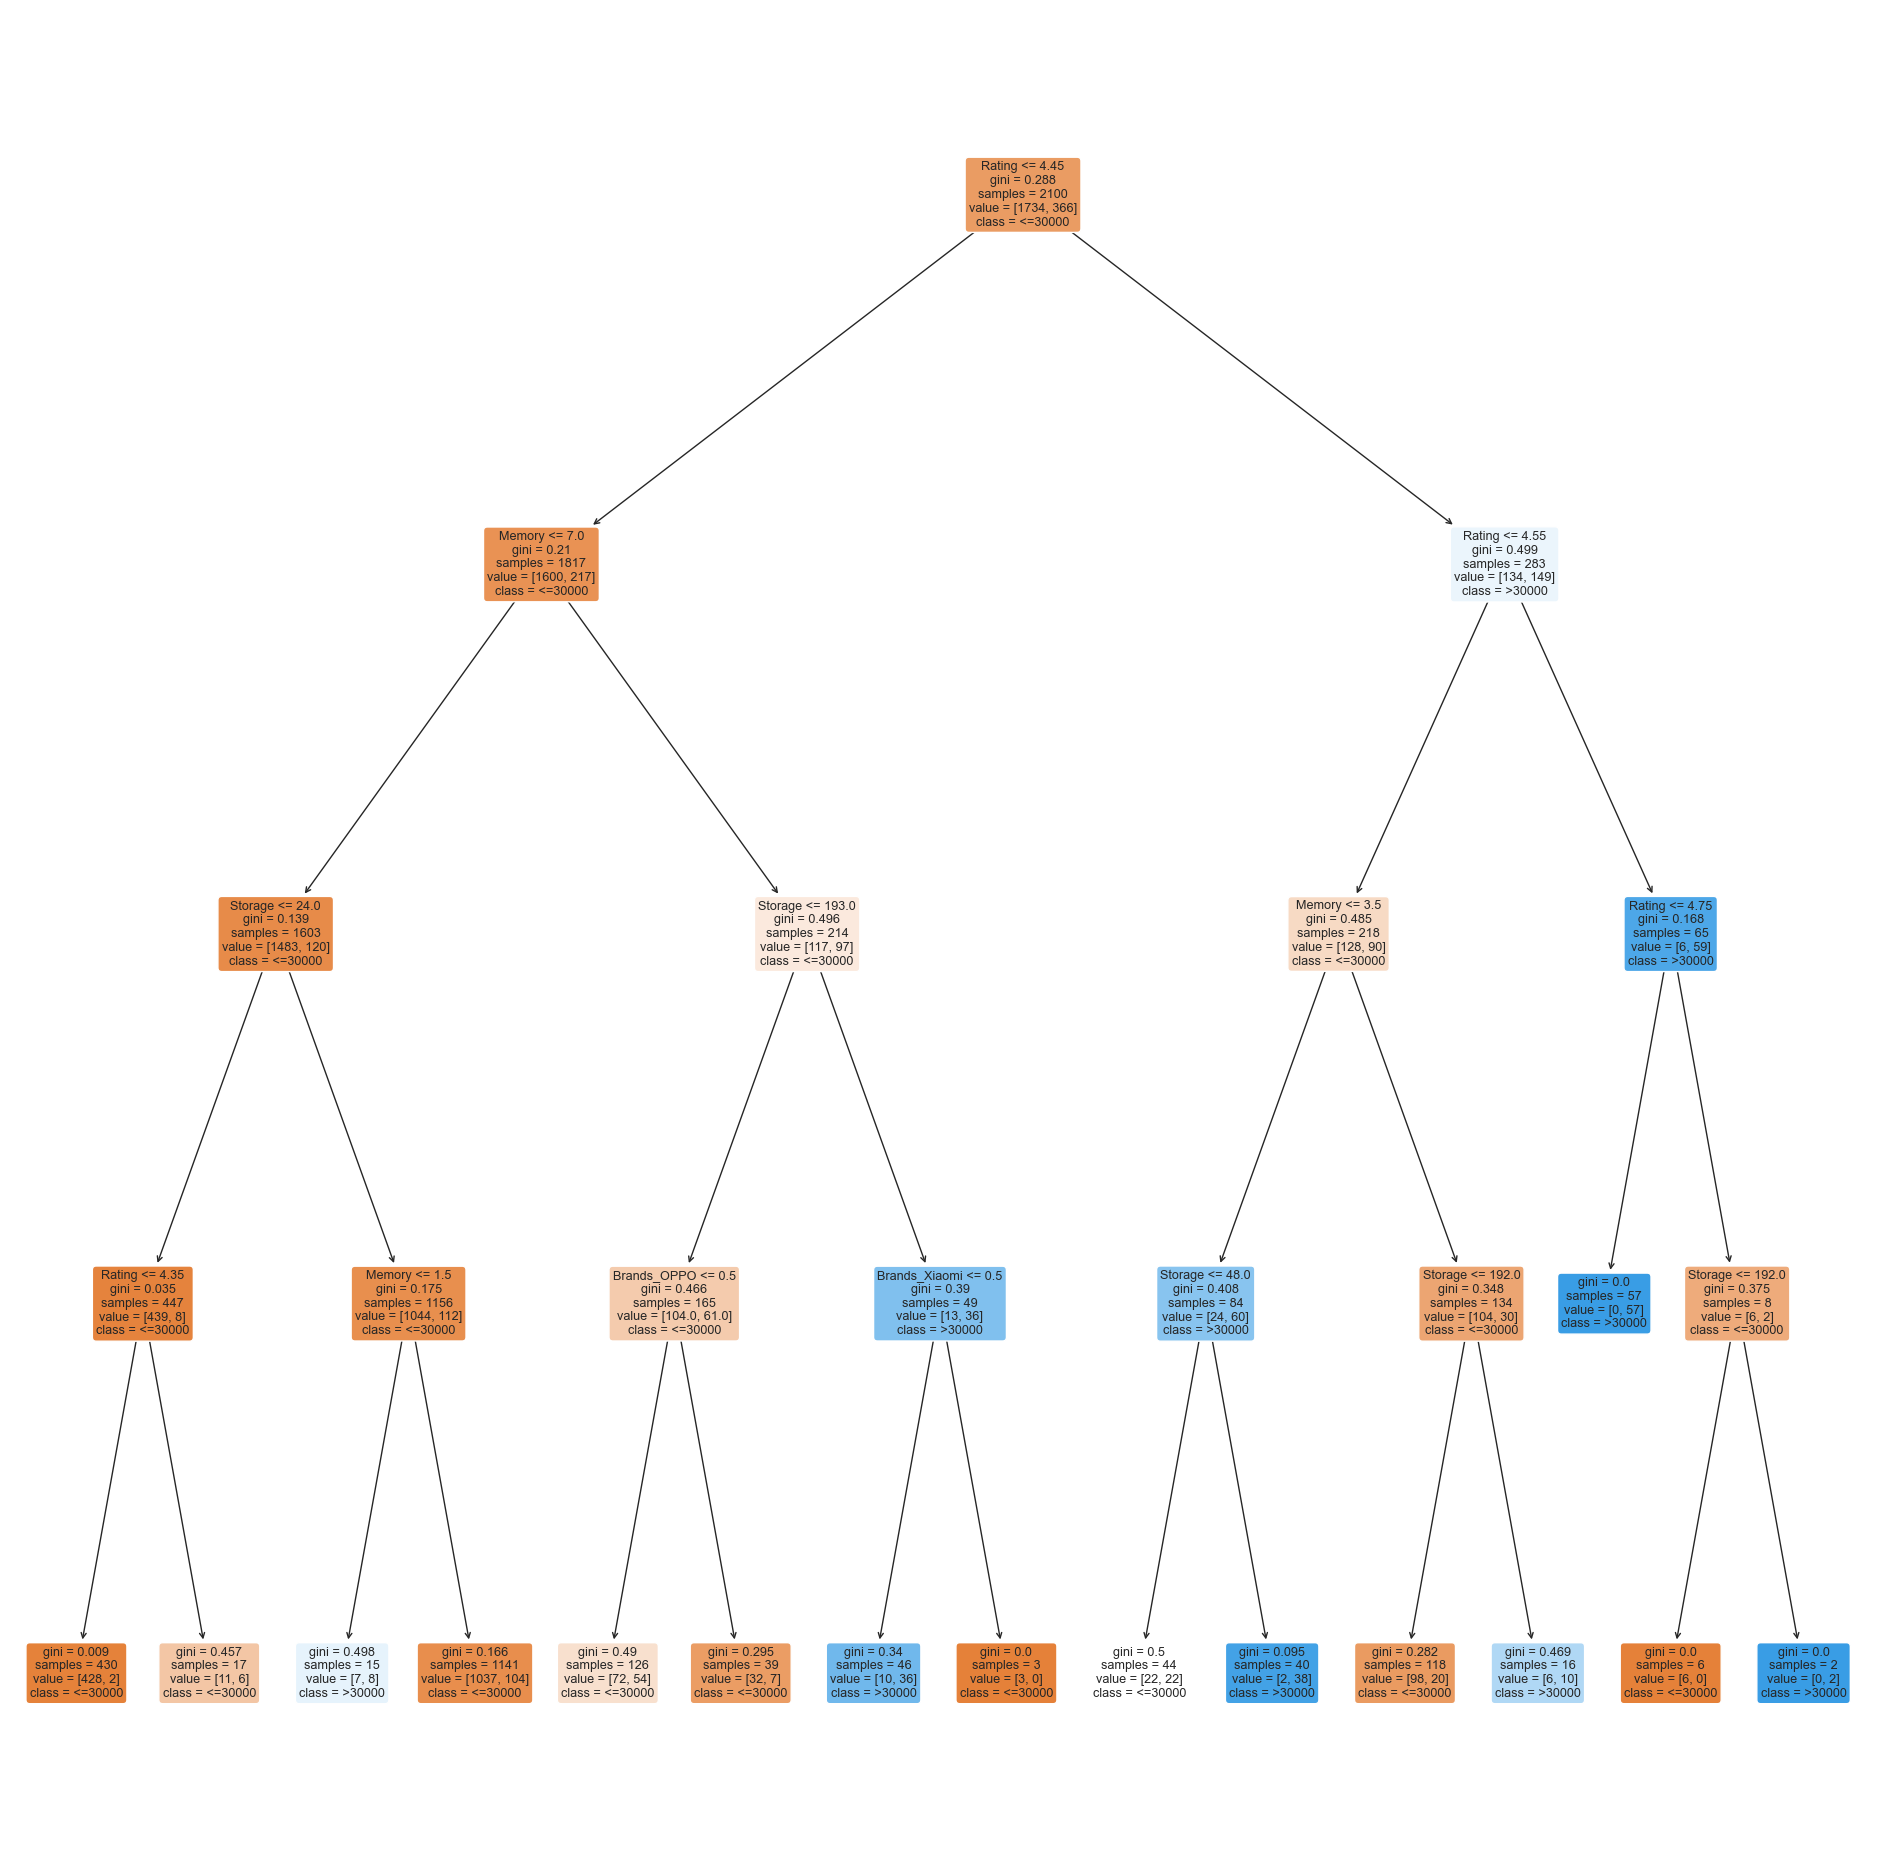

In [28]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

# Extract Response and Predictors
y = pd.DataFrame(filtered_data_ohe['Original Price'])
X = pd.DataFrame(filtered_data_ohe.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["<=30000",">30000"])

Train Data
Accuracy  :	 0.8857142857142857

TPR Train :	 0.412568306010929
TNR Train :	 0.9855824682814303

FPR Train :	 0.01441753171856978
FNR Train :	 0.587431693989071


<Axes: >

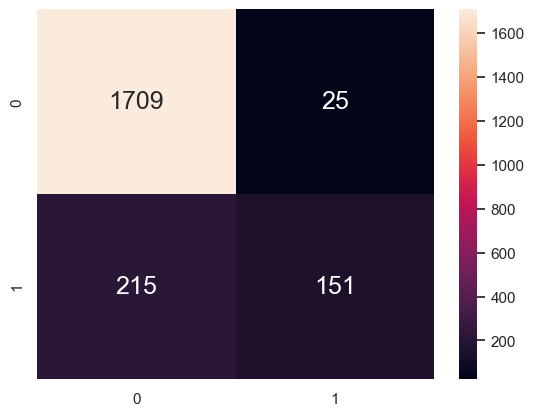

In [29]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Refining the Model

Let's refine the previous model by balancing the classes of the response `Original Price` in the training data. Keeping the OneHotEncoding same as before.

In [30]:
# Upsample >30000 to match <=30000
from sklearn.utils import resample

data_high_price = filtered_data_ohe[filtered_data_ohe["Original Price"] == ">30000"]
data_low_price = filtered_data_ohe[filtered_data_ohe["Original Price"] == "<= 30000"]
 
# Upsample the Bad samples
data_high_price_up = resample(data_high_price, 
                        replace=True,                         # sample with replacement
                        n_samples=data_low_price.shape[0])    # to match number of samples <=30000
 
# Combine the two classes back after upsampling
data_ohe_up = pd.concat([data_high_price_up, data_low_price])
 
# Check the ratio of the classes
data_ohe_up['Original Price'].value_counts()

Original Price
<= 30000    2181
>30000      2181
Name: count, dtype: int64

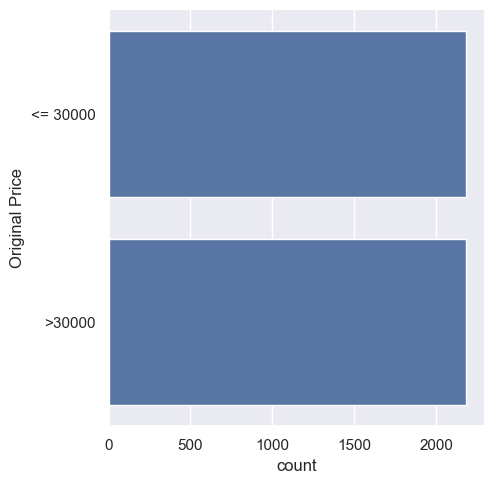

In [31]:
# Quick plot to check the balanced classes visually
sb.catplot(y = 'Original Price', data = data_ohe_up, kind = "count")

In [32]:
# Confirm that the OHE is still in place
# and that the samples have now increased
data_ohe_up.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4362 entries, 2551 to 3113
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Memory               4362 non-null   float64 
 1   Storage              4362 non-null   float64 
 2   Rating               4362 non-null   float64 
 3   Original Price       4362 non-null   category
 4   Brands_ASUS          3708 non-null   float64 
 5   Brands_Apple         3708 non-null   float64 
 6   Brands_GIONEE        3708 non-null   float64 
 7   Brands_Google Pixel  3708 non-null   float64 
 8   Brands_HTC           3708 non-null   float64 
 9   Brands_IQOO          3708 non-null   float64 
 10  Brands_Infinix       3708 non-null   float64 
 11  Brands_LG            3708 non-null   float64 
 12  Brands_Lenovo        3708 non-null   float64 
 13  Brands_Motorola      3708 non-null   float64 
 14  Brands_Nokia         3708 non-null   float64 
 15  Brands_OPPO          37

[Text(0.5, 0.9, 'Rating <= 4.35\ngini = 0.5\nsamples = 3489\nvalue = [1739.0, 1750.0]\nclass = >30000'),
 Text(0.25, 0.7, 'Memory <= 7.0\ngini = 0.434\nsamples = 1932\nvalue = [1317, 615]\nclass = <=30000'),
 Text(0.125, 0.5, 'Storage <= 24.0\ngini = 0.323\nsamples = 1550\nvalue = [1236, 314]\nclass = <=30000'),
 Text(0.0625, 0.3, 'Brands_Infinix <= 0.5\ngini = 0.009\nsamples = 453\nvalue = [451, 2]\nclass = <=30000'),
 Text(0.03125, 0.1, 'gini = 0.0\nsamples = 432\nvalue = [432, 0]\nclass = <=30000'),
 Text(0.09375, 0.1, 'gini = 0.172\nsamples = 21\nvalue = [19, 2]\nclass = <=30000'),
 Text(0.1875, 0.3, 'Memory <= 5.0\ngini = 0.407\nsamples = 1097\nvalue = [785.0, 312.0]\nclass = <=30000'),
 Text(0.15625, 0.1, 'gini = 0.361\nsamples = 783\nvalue = [598, 185]\nclass = <=30000'),
 Text(0.21875, 0.1, 'gini = 0.482\nsamples = 314\nvalue = [187, 127]\nclass = <=30000'),
 Text(0.375, 0.5, 'Brands_Xiaomi <= 0.5\ngini = 0.334\nsamples = 382\nvalue = [81, 301]\nclass = >30000'),
 Text(0.3125, 

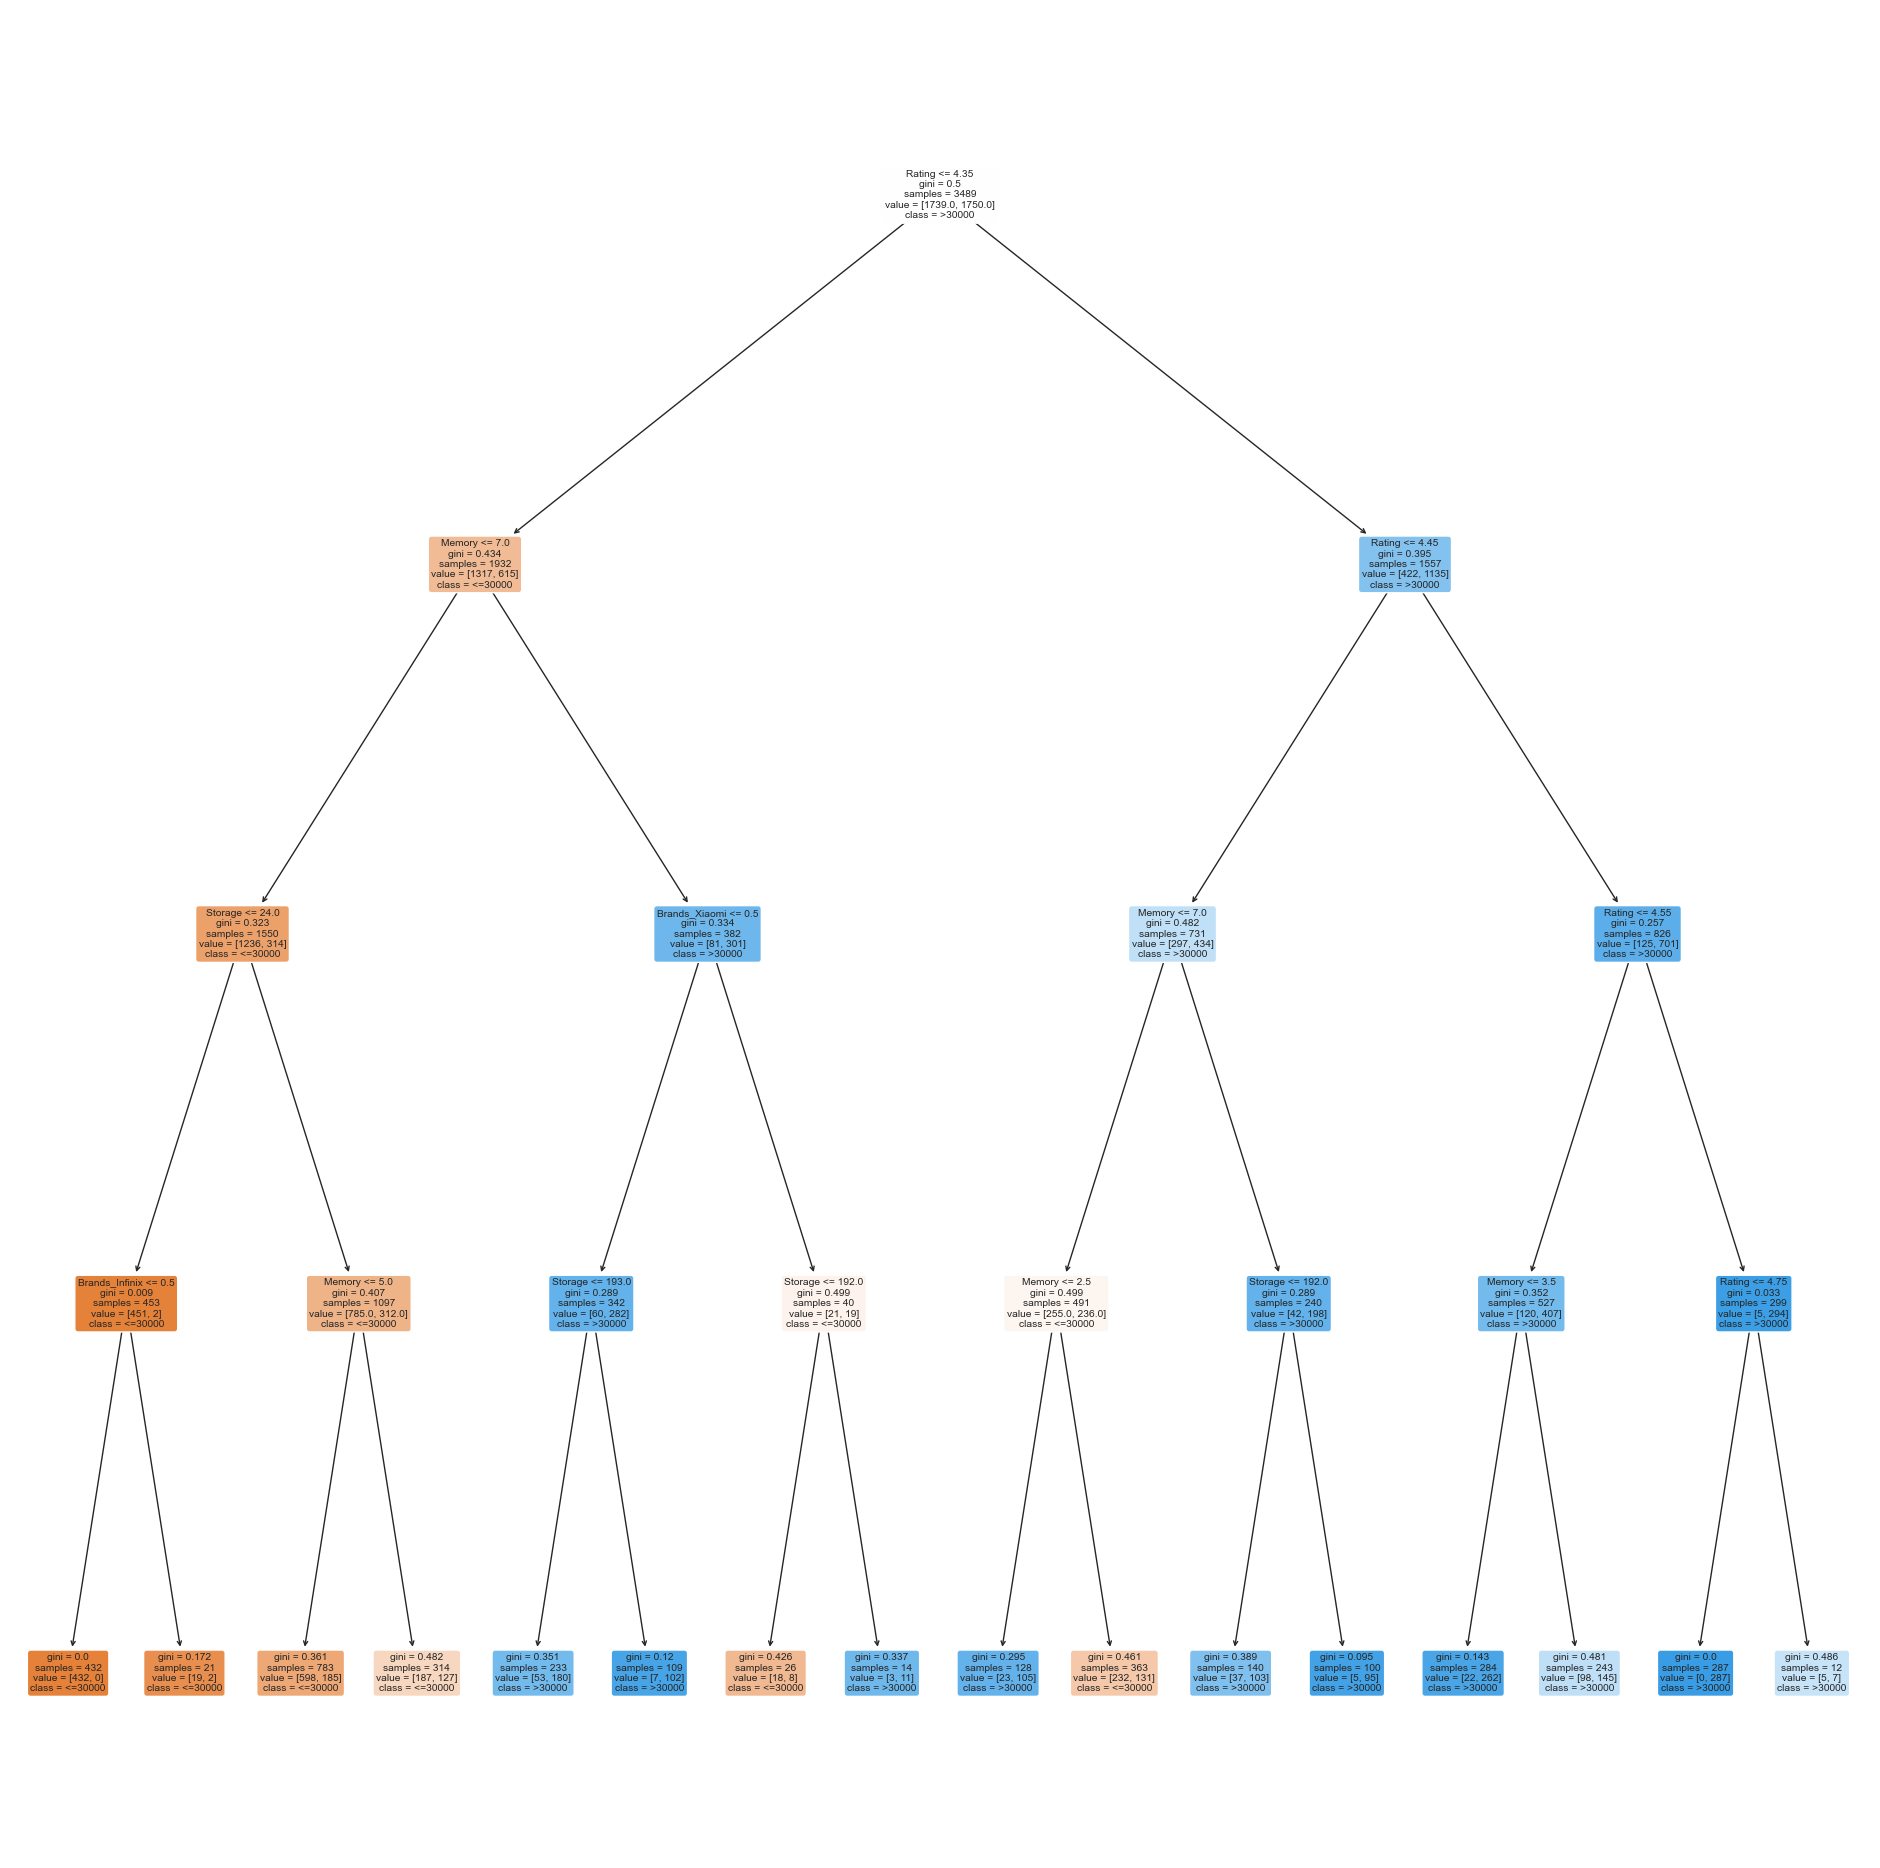

In [33]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["<=30000",">30000"])

Train Data
Accuracy  :	 0.7976497563771855

TPR Train :	 0.7411428571428571
TNR Train :	 0.8545140885566418

FPR Train :	 0.14548591144335826
FNR Train :	 0.25885714285714284


<Axes: >

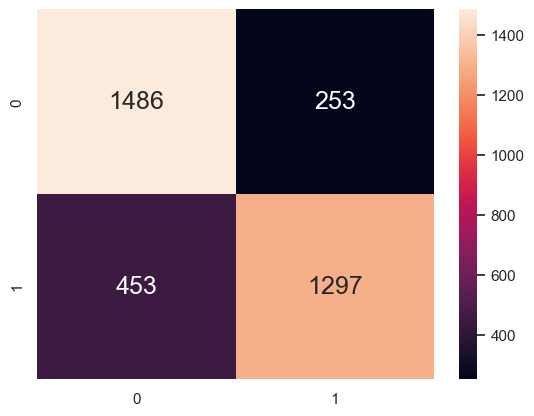

In [34]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8064146620847652

TPR Test :	 0.7470997679814385
TNR Test :	 0.8642533936651584

FPR Test :	 0.13574660633484162
FNR Test :	 0.2529002320185615


<Axes: >

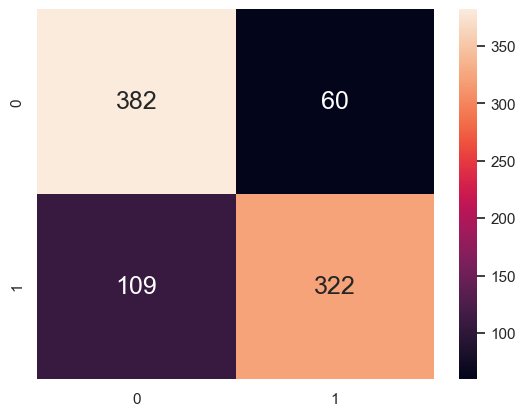

In [35]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Further refinement of Prediction Model

Using an ensemble of trees for better classification, tree based classifier -- `RandomForest`

In [36]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train['Original Price'].to_numpy())

RandomForestClassifier(max_depth=4)

Train Data
Accuracy  :	 0.7965032960733734

TPR Train :	 0.7362637362637363
TNR Train :	 0.8556818181818182

FPR Train :	 0.14431818181818182
FNR Train :	 0.26373626373626374


<Axes: >

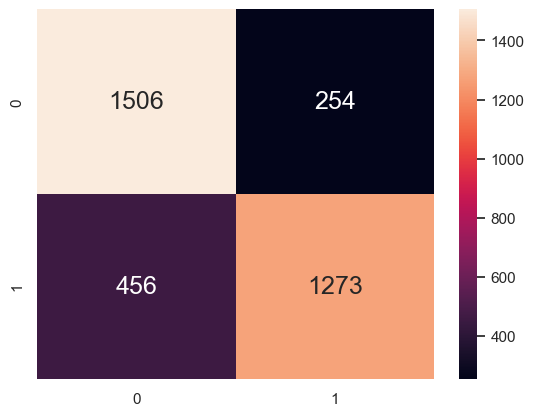

In [37]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8109965635738832

TPR Test :	 0.7654867256637168
TNR Test :	 0.8598574821852731

FPR Test :	 0.14014251781472684
FNR Test :	 0.2345132743362832


<Axes: >

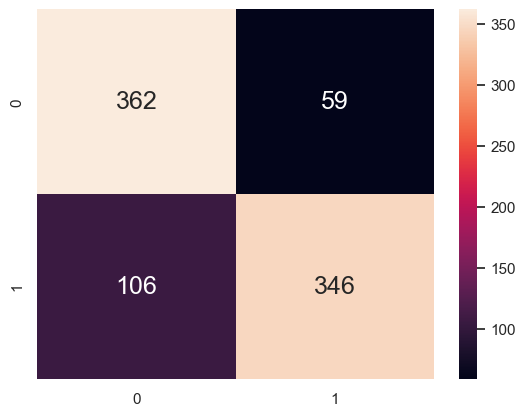

In [38]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Using GridSearch

In [45]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train['Original Price'].to_numpy())

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

### Use the Best Model found through GridSearchCV

In [ ]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 200,   # found using GridSearchCV
                                 max_depth = 10)       # found using GridSearchCV

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train["Original Price"].to_numpy())

Train Data
Accuracy  :	 0.8612783032387503

TPR Train :	 0.8419838523644751
TNR Train :	 0.8803418803418803

FPR Train :	 0.11965811965811966
FNR Train :	 0.1580161476355248


<Axes: >

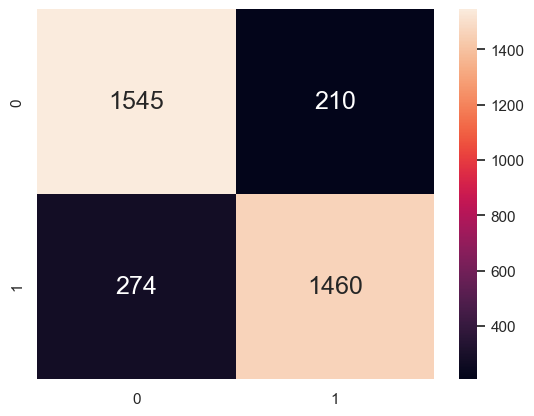

In [43]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8224513172966781

TPR Test :	 0.796420581655481
TNR Test :	 0.8497652582159625

FPR Test :	 0.15023474178403756
FNR Test :	 0.203579418344519


<Axes: >

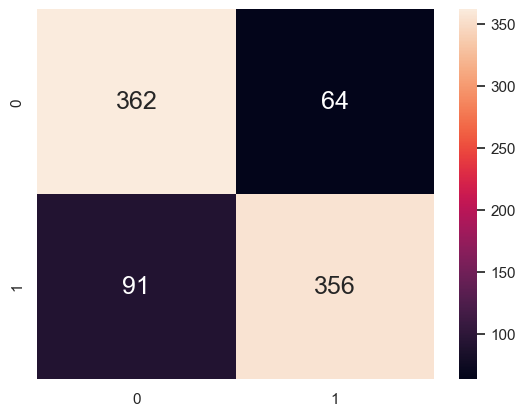

In [44]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})